このPython コードは、PyMC を使ってMCMCサンプリングを行います。
* 2025年8月時点では、Google Colaboratory環境では PyMC がそのまま使えますので、実行可能です。
* ローカルな計算機環境では、PyMC パッケージが含まれていないのが一般的です。
    * 例えば、Anaconda などの Distribution では、以下の例の様に、PyMC環境を用意する必要があります。
        ```
        conda create -c conda-forge -n pymc_env pymc
        conda activate pymc_env
        conda install conda-forge::ipywidgets
        conda install scikit-learn
        ```
        * これで VS codeの実行時のPython環境に、```pymc_env```を選択します。

In [ ]:
############################################
BaseDir      = 'IntroDDSJpn/Chap02/'
OutputDir    = '2PyMC-0502Line-02/'
FileBaseName = '2PyMC-0502Line-02'

* Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [ ]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

Mounted at /content/drive
ipynb file path = drive/My Drive/Colab Notebooks/IntroDDS/Chap02/


* 必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
print('numpy      Ver.', np.__version__)
#
############################################
# https://docs.pymc.io/
import pymc as pm
import time
print('pymc       Ver.', pm.__version__)
#
############################################
import pickle
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.7.1
numpy      Ver. 1.26.4
pymc       Ver. 5.10.4
FilePath = drive/My Drive/Colab Notebooks/IntroDDS/Chap02/2PyMC-0702Line-02/
  making drive/My Drive/Colab Notebooks/IntroDDS/Chap02/2PyMC-0702Line-02/


最確値を書式化して文字列として返す関数
```
Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False )
```
*   返値: 書式化された文字列を返す。
*   v_mean: 平均値
*   v_std:  標準偏差
*   s_unit: 値の単位(文字列)
*   std_2digit=True: 標準偏差を2桁表示。Falseにすると1桁表示
*   latex=False: テキスト文字列として出力。Trueでは、図などでlatex表示できる文字列で出力。

In [4]:
def Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False ):
  #
  # 平均値の冪数
  order_mean = np.floor( np.log10(v_mean) )
  # print( 'order_mean=', order_mean )
  #
  # 標準偏差の冪数
  if std_2digits:
    # 標準偏差を有効2桁表示
    order_std  = np.floor( np.log10(v_std) - 1.0 )
  else:
    # 標準偏差を有効1桁表示
    order_std  = np.floor( np.log10(v_std) - 0.0 )
  # print( 'order_std=', order_std )
  #
  # 平均値の冪数と標準偏差の冪数の符号が同じか?
  if order_mean * order_std > 0.0:
    # 例1
    # v_mean = 4.60572E5
    # v_std  = 8.96E3
    # 例2
    # v_mean = 4.605723E-2
    # v_std  = 8.96E-5
    multi_order = order_std+1
    #
    # 共通する冪数
    multi = 10.0**multi_order
    #
    # 共通する冪数で規格化
    v_mean = v_mean / multi
    v_std  = v_std  / multi
    #
    # 共通した冪数で指数をくくって、係数は少数第1位
    if latex:
      out_str = r'(%+.1f $\pm$ %.1f)$\times10^{%+d}$ ' % (v_mean, v_std, multi_order) + s_unit
    else:
      out_str = '(%+.1f +/- %.1f)x10^(%+d) ' % (v_mean, v_std, multi_order) + s_unit
    #
  else:
    # 平均値の冪数と標準偏差の冪数の符号が異なる
    # 例2
    # v_mean = 4.605723
    # v_std  = 0.0896
    fmt_std1 = r'$%%+.%df$' % -order_std
    fmt_std2 = r'$%%.%df$'  % -order_std
    if latex:
      fmt_str = fmt_std1 + r' $\pm$ ' + fmt_std2 + ' ' + s_unit
    else:
      fmt_str = fmt_std1 + ' +/- ' + fmt_std2 + ' ' + s_unit
    #
    out_str = fmt_str % (v_mean, v_std)
  #
  return out_str

---
直線回帰の例2
1. 直線の関数:  $f(x;a,b)=a\,x+b$
    * $a$: 勾配 (真値: $a_{\rm true}=2.0$)
    * $b$: 切片 (真値: $b_{\rm true}=0.3$)

2. データの諸元
    * $x=-2.5\sim+2.5$
    * データ点数: $N=501$

In [5]:
############################################
N = 501
#
X = np.linspace(-2.5,2.5, num=N, endpoint=True )
#
print('X: %.3f ~ %.3f (N = %d)' %
      (np.amin(X), np.amax(X), X.size))
print('X: mean = %.3f, std = %.3f' %
      (np.mean(X), np.std(X)))
#
a_true = 2.0
b_true = 0.3
#
print('gradient  a_true = %.3f' % a_true)
print('intercept b_true = %.3f' % b_true)
#
############################################
def linefunc(x, a, b):
  return a * x + b
#
Y_true = linefunc( X, a_true, b_true )
#
print('Y_true: %.3f ~ %.3f (N = %d)' %
      (np.amin(Y_true), np.amax(Y_true), Y_true.size))
print('Y_true: mean = %.3f, std = %.3f' %
      (np.mean(Y_true), np.std(Y_true)))

X: -2.500 ~ 2.500 (N = 501)
X: mean = 0.000, std = 1.446
gradient  a_true = 2.000
intercept b_true = 0.300
Y_true: -4.700 ~ 5.300 (N = 501)
Y_true: mean = 0.300, std = 2.893


3. 重畳する正規ノイズ ${\cal N}(\mu=0.0,\sigma)$
    * 設定平均値:  $\mu=0.0$
    * 設定標準偏差:  $\sigma=2.0\times10^{-2}\sim2.0\times10^{0}$

4. 解析対象データ: $y_{i}=f(x_{i};a_{\rm true}, b_{\rm true})+{\cal N}(\mu=0.0,\sigma)$

In [6]:
############################################
sigma_noise_min = np.log10(2E-2)
sigma_noise_max = np.log10(2E0)
#
sigma_noises = np.logspace( \
                    sigma_noise_min, \
                    sigma_noise_max, \
                    num=10)
print(sigma_noises)

[0.02       0.03336201 0.05565119 0.09283178 0.15485274 0.25830993
 0.43088694 0.71876273 1.1989685  2.        ]


5. グラフを描く関数

In [7]:
######################################
# Ysets = [
#           [Ydata1, Ylabel1, Ystyle1, Ycolor1],
#           [Ydata2, Ylabel2, Ystyle2, Ycolor2]
#         ]
# Ystyle = {1=plot, 2=scatter}
######################################
def grf_line(X, Ysets, title ):
    #
    plt.rcParams['font.size'] = 16
    #
    fig = plt.figure( figsize=(6,6) )
    fig.subplots_adjust( left=0.15, right=0.98, top=0.93,  bottom=0.1 )
    #
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    #
    for Yset in Ysets:
      #
      Ydata  = Yset[0]
      Ylabel = Yset[1]
      Ystyle = Yset[2]
      Ycolor = Yset[3]
      #
      if( Ystyle == 1 ):   # plot
        #
        ax1.plot(X, Ydata, color=Ycolor, linewidth=2.0, label=Ylabel )
        #
      elif( Ystyle == 2 ): # scatter
        #
        ax1.scatter(X, Ydata, color=Ycolor, s=10.0, label=Ylabel )
        #
    #
    (x_left, x_right) = ax1.set_xlim()
    (y_bot, y_top) = ax1.set_ylim()
    #
    ax1.hlines(0, x_left, x_right, linestyles='dashed', linewidth=1.0)
    ax1.vlines(0, y_bot,  y_top,   linestyles='dashed', linewidth=1.0)
    #
    plt.title( title )
    plt.legend(fontsize=12)
    #
    plt.show()
    #
    return fig

In [8]:
######################################
def grf_linebk(X, Y_true, Y, label_Y_true, label_Y, title ):
    #
    plt.rcParams['font.size'] = 16
    #
    fig = plt.figure( figsize=(6,6) )
    fig.subplots_adjust( left=0.15, right=0.98, top=0.93,  bottom=0.1 )
    #
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    #
    ax1.plot(X, Y_true, color='red', linewidth=2.0, label=label_Y_true )
    #
    ax1.scatter(X, Y, color='blue',  s=10.0, label=label_Y )
    #
    (x_left, x_right) = ax1.set_xlim()
    (y_bot, y_top) = ax1.set_ylim()
    #
    # Origin
    ax1.hlines(0, x_left, x_right, linestyles='dashed', linewidth=1.0)
    ax1.vlines(0, y_bot,  y_top,   linestyles='dashed', linewidth=1.0)
    #
    plt.title( title )
    plt.legend(fontsize=12)
    #
    plt.show()
    #
    return fig

* 各$\sigma$で以下の解析を行う。

6. 解析データの準備とグラフの描画と出力

7. $a$, $b$の事後確率分布
$$
P(a|\boldsymbol{D})
=
\sqrt{
  \frac{
    M
    \overline{x^2}
  }{
    2\pi
    \sigma_{\rm noise}^{2}
  }
}
\exp
\left[
  -
  \frac{
    M
    \overline{x^2}
  }{
    2
    \sigma_{\rm noise}^{2}
  }
  \left(
    a-a_{0}
  \right)^2
\right]
$$

$$
P(b|\boldsymbol{D})
=
\sqrt{
  \frac{
    M
  }{
    2\pi
    \sigma_{\rm noise}^{2}
  }
}
\exp
\left[
  -
  \frac{
    M
  }{
    2
    \sigma_{\rm noise}^{2}
  }
  \left(
    b-b_{0}
  \right)^2
\right]
$$

8. $a$, $b$の事後確率分布の標準偏差
$$
\sigma_{P(a|\boldsymbol{D})}
=
\frac{
  \sigma_{\rm noise}
}{
  \sqrt{
    M
    \overline{x^2}
  }
}
$$

$$
\sigma_{P(b|\boldsymbol{D})}
=
\frac{
  \sigma_{\rm noise}
}{
  \sqrt{
    M
  }
}
$$

9. $a$, $b$の事前確率の設定

* $P(a)={\cal N}(\mu=0.0,\sigma=2.0)$
* $P(b)={\cal N}(\mu=0.0,\sigma=1.0)$

10. PyMCによるサンプリング

11. 事後確率分布の描画と出力

<ipython-input-9-e377ad2d3472>:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_mean = float( summary_a['mean'] )
<ipython-input-9-e377ad2d3472>:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_sd   = float( summary_a['sd'] )
<ipython-input-9-e377ad2d3472>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mean = float( summary_b['mean'] )
<ipython-input-9-e377ad2d3472>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_sd   = float( summary_b['sd'] )
<ipython-input-9-e377ad2d3472>:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the f

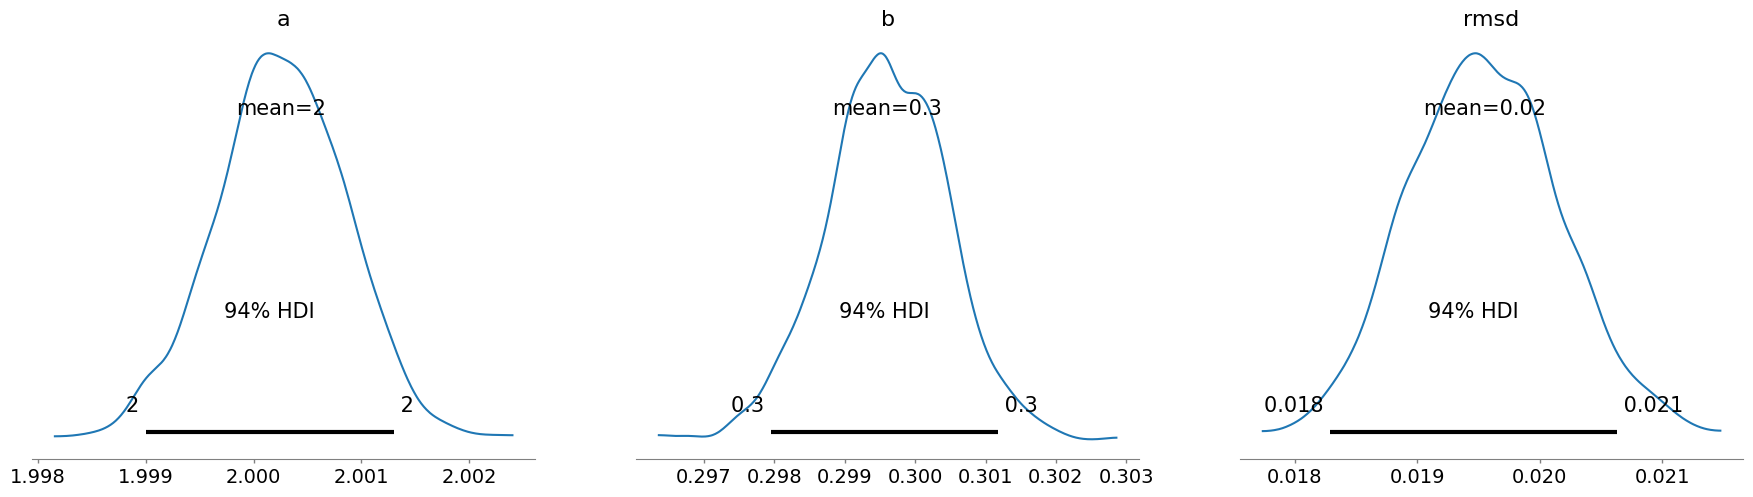

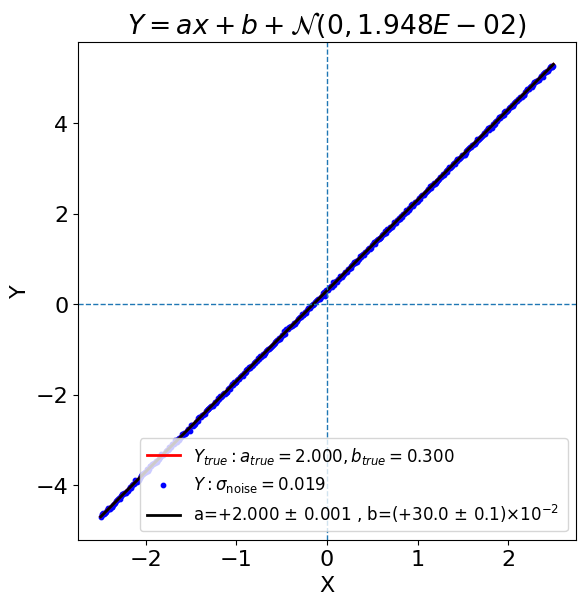

<ipython-input-9-e377ad2d3472>:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_mean = float( summary_a['mean'] )
<ipython-input-9-e377ad2d3472>:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_sd   = float( summary_a['sd'] )
<ipython-input-9-e377ad2d3472>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mean = float( summary_b['mean'] )
<ipython-input-9-e377ad2d3472>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_sd   = float( summary_b['sd'] )
<ipython-input-9-e377ad2d3472>:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the f

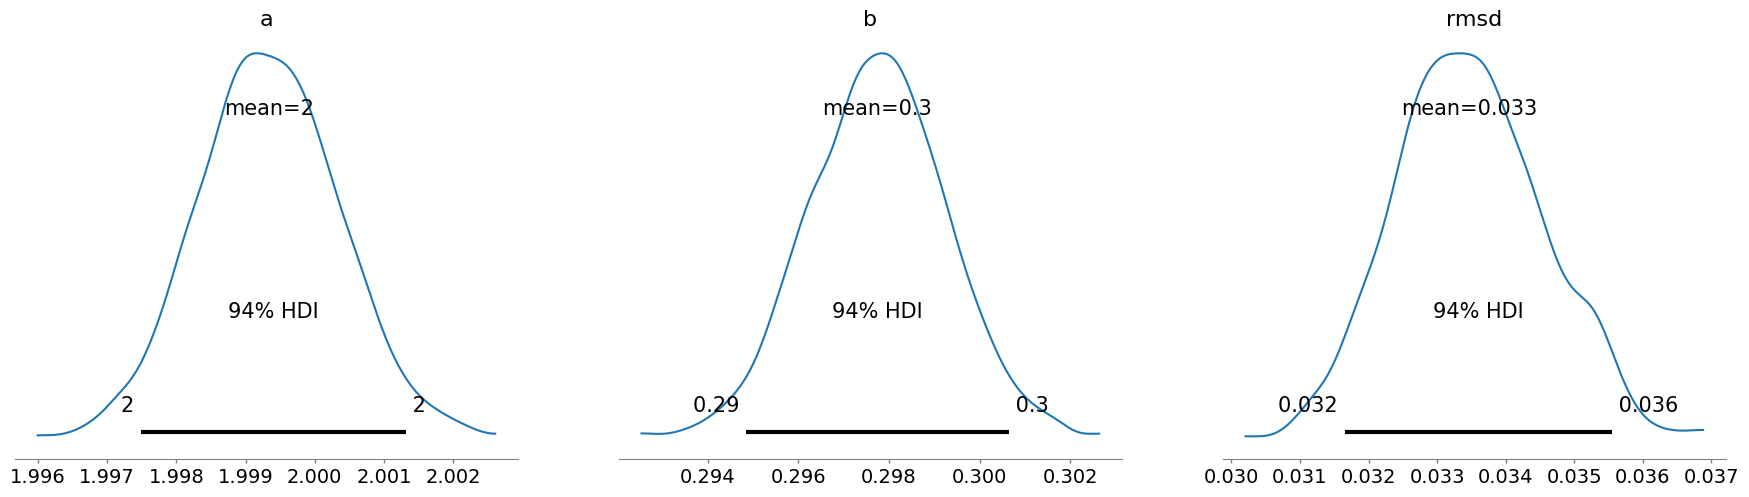

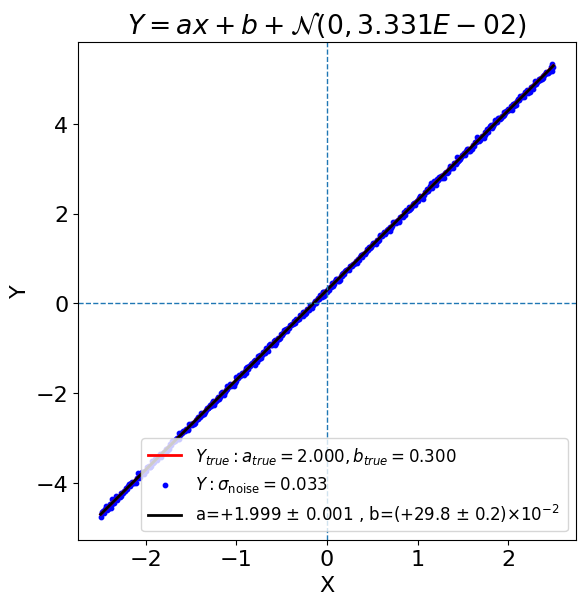

<ipython-input-9-e377ad2d3472>:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_mean = float( summary_a['mean'] )
<ipython-input-9-e377ad2d3472>:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_sd   = float( summary_a['sd'] )
<ipython-input-9-e377ad2d3472>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mean = float( summary_b['mean'] )
<ipython-input-9-e377ad2d3472>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_sd   = float( summary_b['sd'] )
<ipython-input-9-e377ad2d3472>:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the f

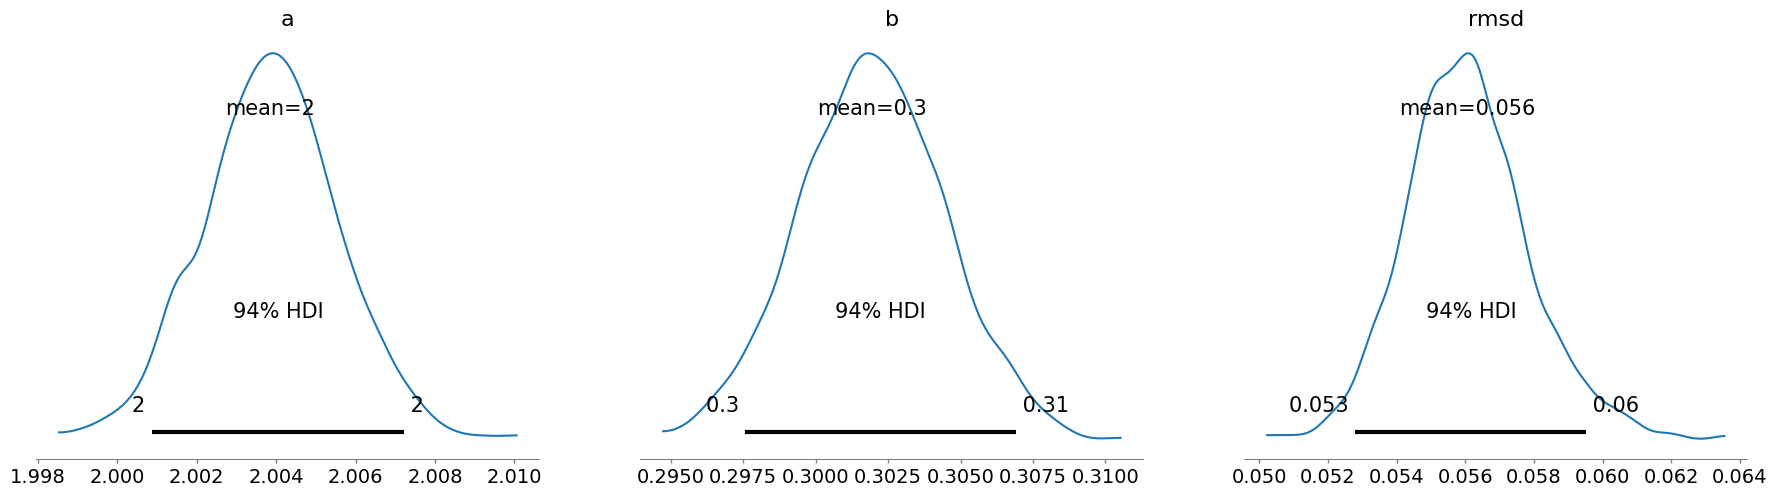

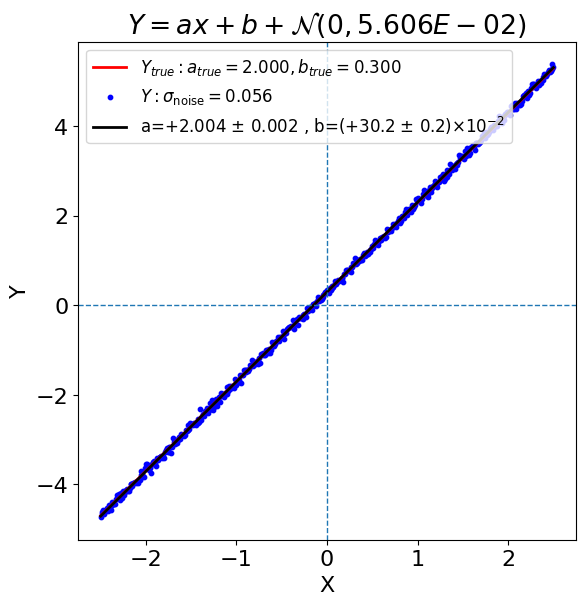

<ipython-input-9-e377ad2d3472>:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_mean = float( summary_a['mean'] )
<ipython-input-9-e377ad2d3472>:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_sd   = float( summary_a['sd'] )
<ipython-input-9-e377ad2d3472>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mean = float( summary_b['mean'] )
<ipython-input-9-e377ad2d3472>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_sd   = float( summary_b['sd'] )
<ipython-input-9-e377ad2d3472>:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the f

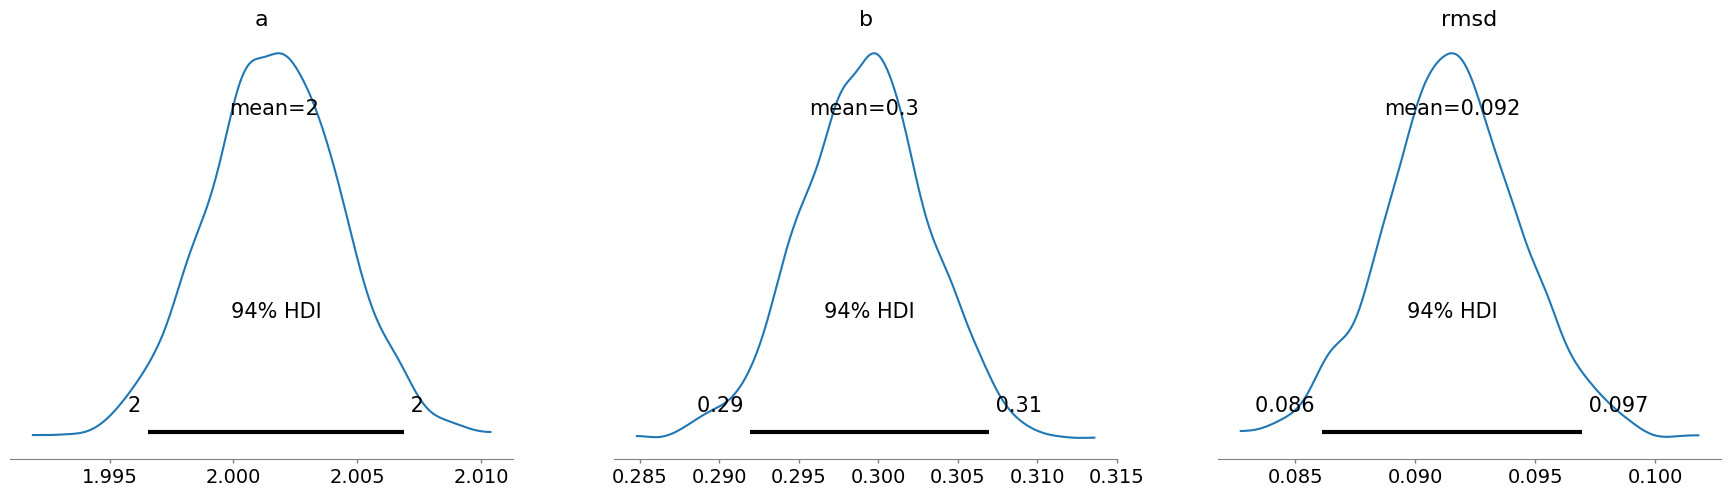

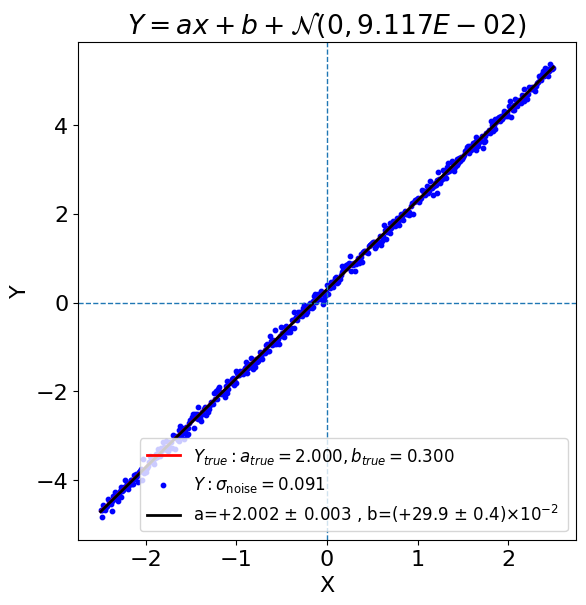

<ipython-input-9-e377ad2d3472>:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_mean = float( summary_a['mean'] )
<ipython-input-9-e377ad2d3472>:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_sd   = float( summary_a['sd'] )
<ipython-input-9-e377ad2d3472>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mean = float( summary_b['mean'] )
<ipython-input-9-e377ad2d3472>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_sd   = float( summary_b['sd'] )
<ipython-input-9-e377ad2d3472>:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the f

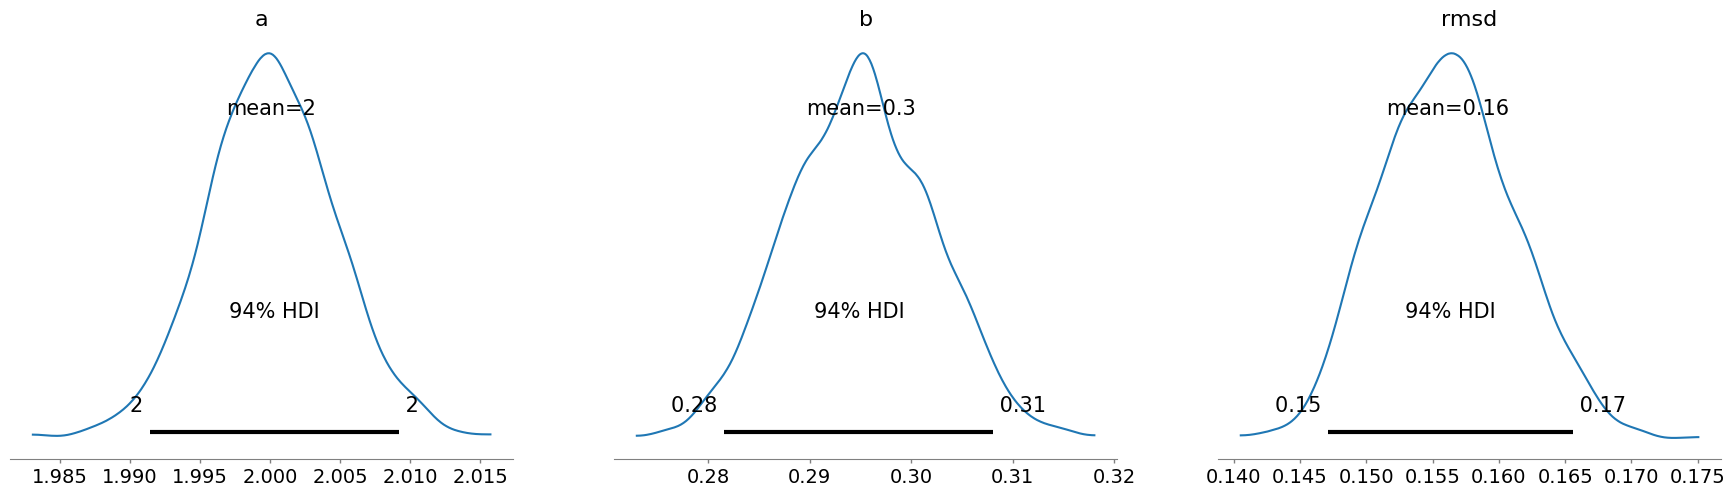

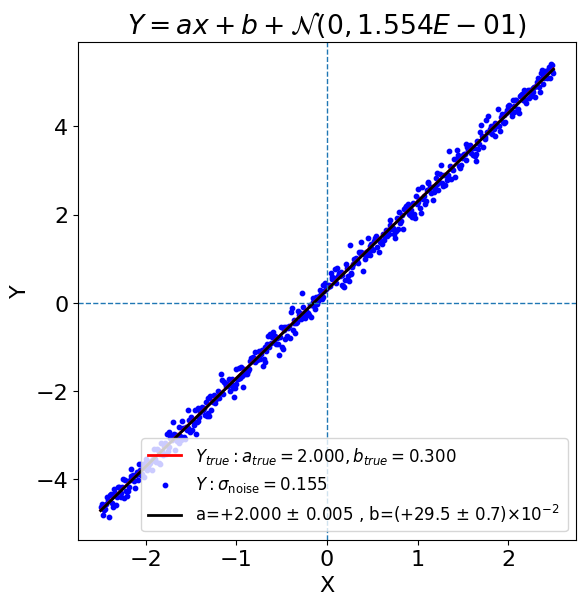

<ipython-input-9-e377ad2d3472>:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_mean = float( summary_a['mean'] )
<ipython-input-9-e377ad2d3472>:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_sd   = float( summary_a['sd'] )
<ipython-input-9-e377ad2d3472>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mean = float( summary_b['mean'] )
<ipython-input-9-e377ad2d3472>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_sd   = float( summary_b['sd'] )
<ipython-input-9-e377ad2d3472>:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the f

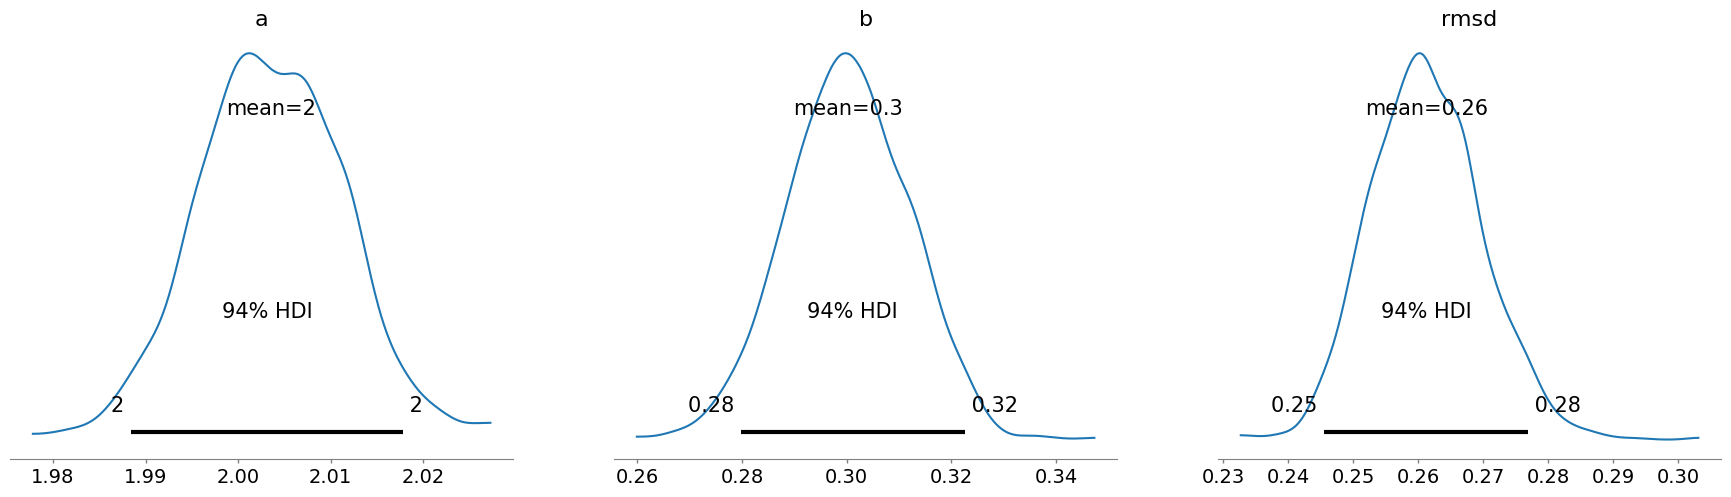

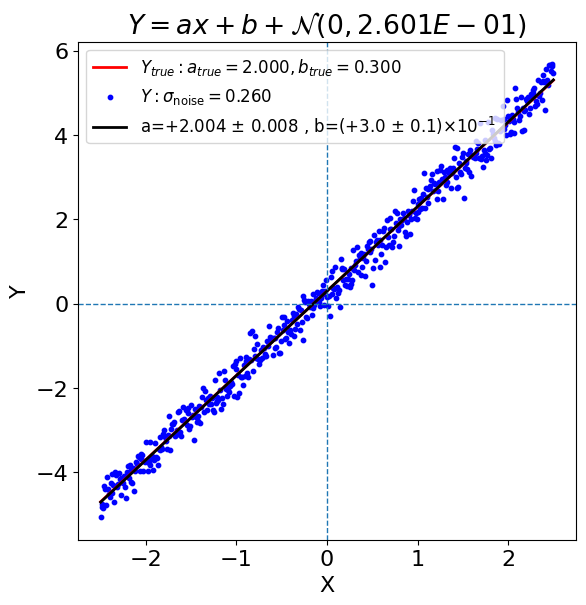

<ipython-input-9-e377ad2d3472>:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_mean = float( summary_a['mean'] )
<ipython-input-9-e377ad2d3472>:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_sd   = float( summary_a['sd'] )
<ipython-input-9-e377ad2d3472>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mean = float( summary_b['mean'] )
<ipython-input-9-e377ad2d3472>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_sd   = float( summary_b['sd'] )
<ipython-input-9-e377ad2d3472>:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the f

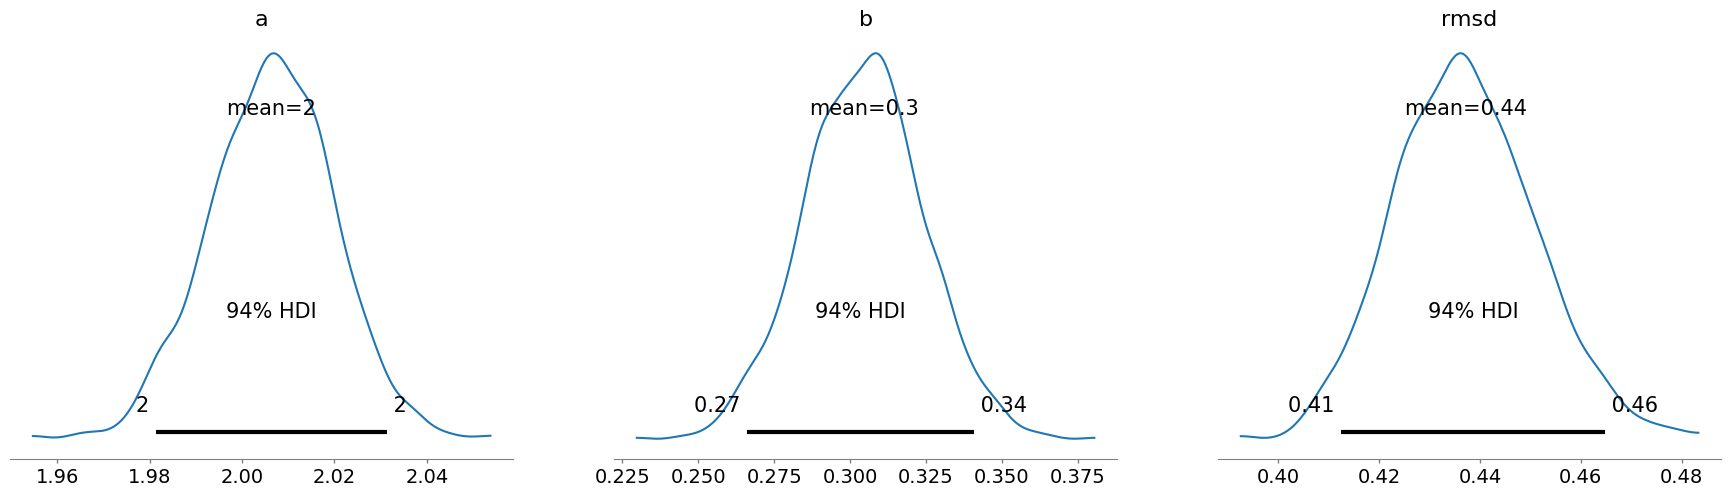

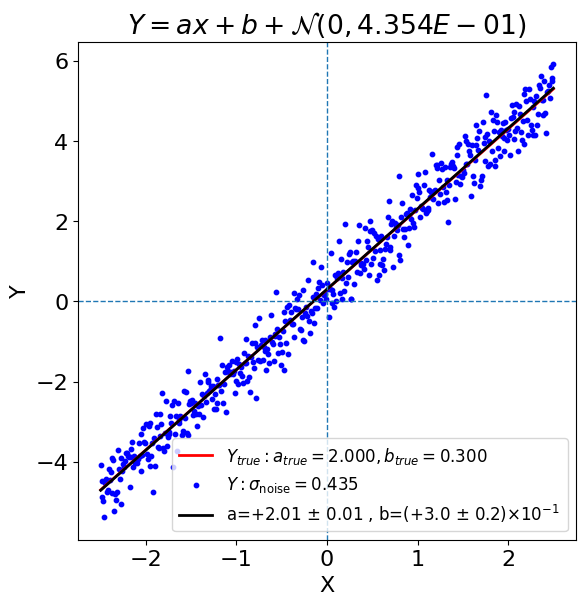

<ipython-input-9-e377ad2d3472>:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_mean = float( summary_a['mean'] )
<ipython-input-9-e377ad2d3472>:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_sd   = float( summary_a['sd'] )
<ipython-input-9-e377ad2d3472>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mean = float( summary_b['mean'] )
<ipython-input-9-e377ad2d3472>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_sd   = float( summary_b['sd'] )
<ipython-input-9-e377ad2d3472>:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the f

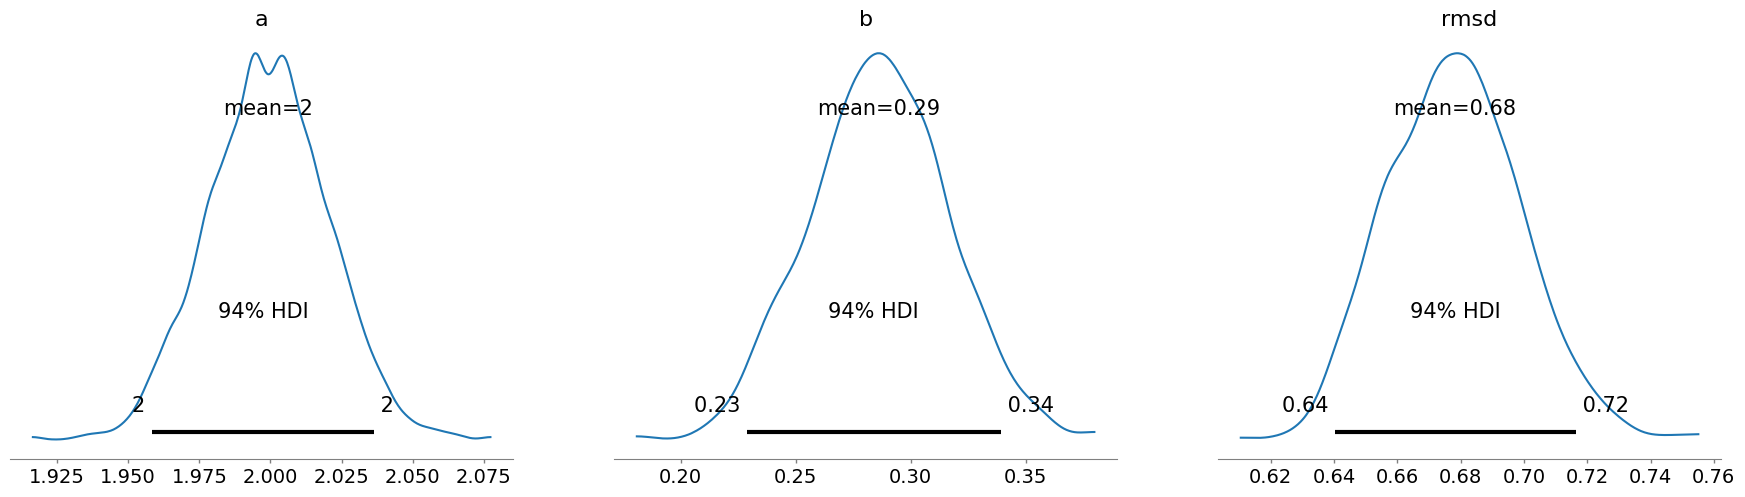

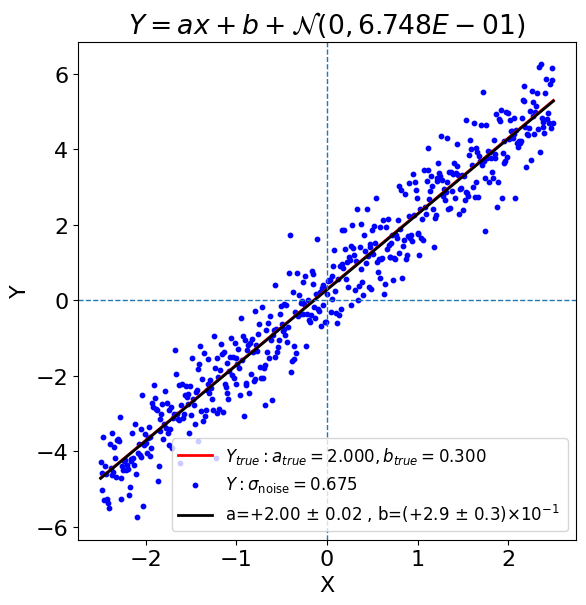

<ipython-input-9-e377ad2d3472>:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_mean = float( summary_a['mean'] )
<ipython-input-9-e377ad2d3472>:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_sd   = float( summary_a['sd'] )
<ipython-input-9-e377ad2d3472>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mean = float( summary_b['mean'] )
<ipython-input-9-e377ad2d3472>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_sd   = float( summary_b['sd'] )
<ipython-input-9-e377ad2d3472>:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the f

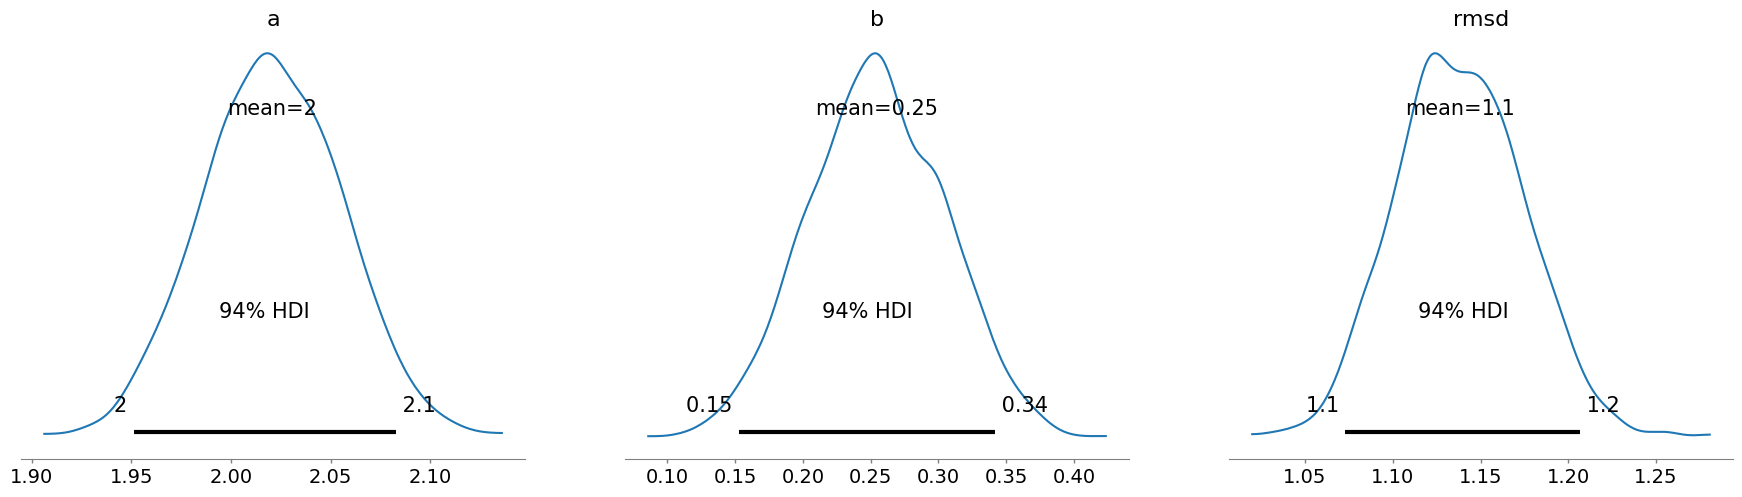

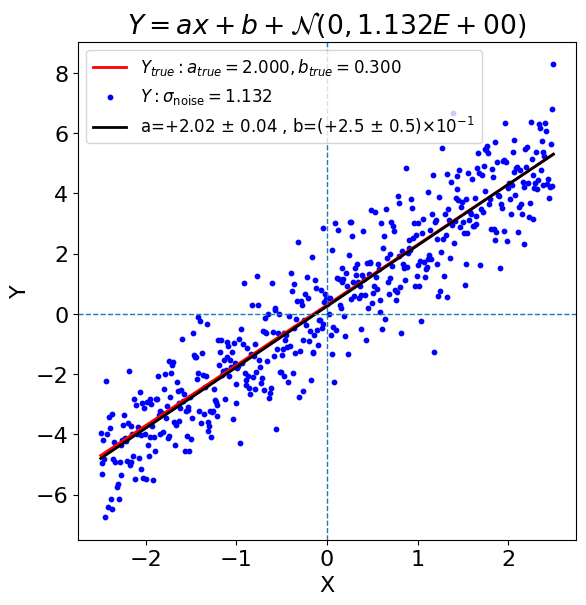

<ipython-input-9-e377ad2d3472>:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_mean = float( summary_a['mean'] )
<ipython-input-9-e377ad2d3472>:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_sd   = float( summary_a['sd'] )
<ipython-input-9-e377ad2d3472>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mean = float( summary_b['mean'] )
<ipython-input-9-e377ad2d3472>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_sd   = float( summary_b['sd'] )
<ipython-input-9-e377ad2d3472>:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the f

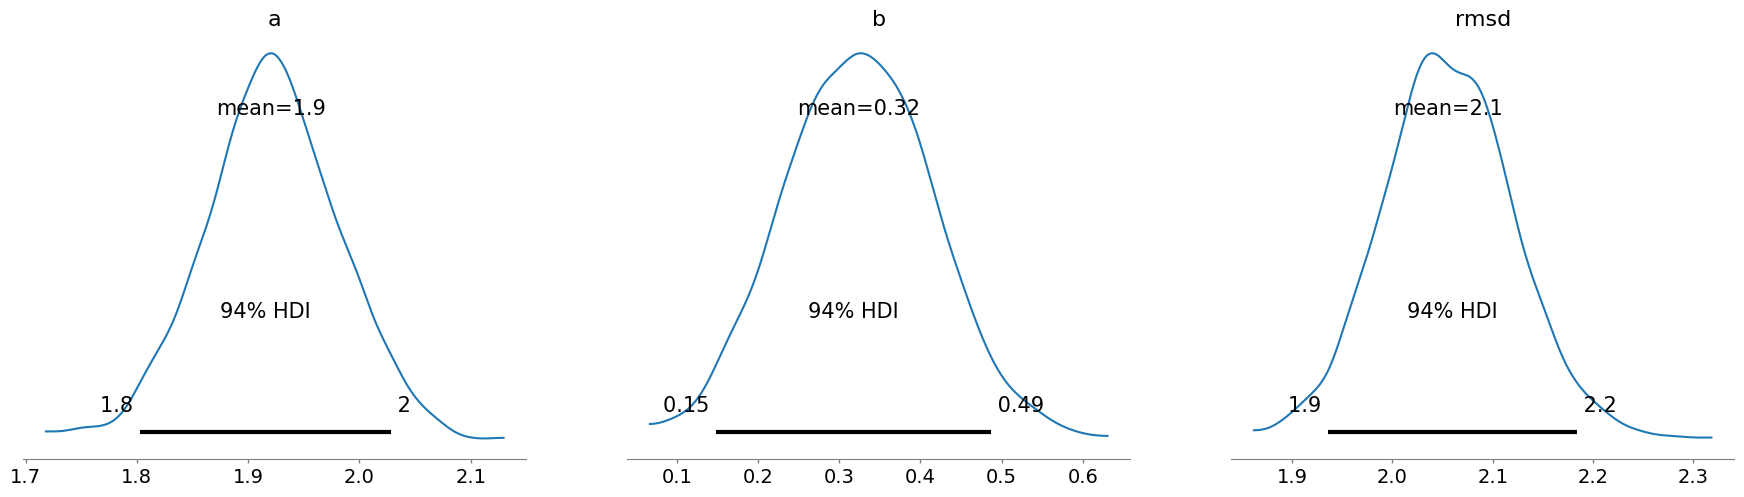

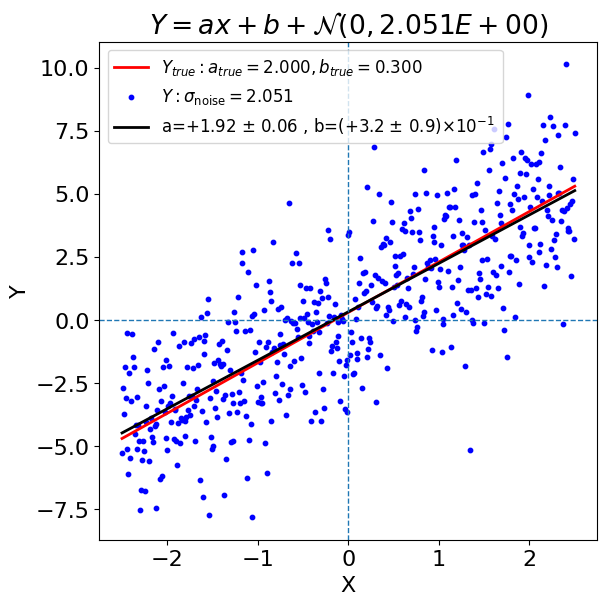

In [9]:
############################################
Y_noise_means = []
Y_noise_stds  = []
sigmas_a      = []
sigmas_b      = []
a_means       = []
a_sds         = []
b_means       = []
b_sds         = []
rmsd_means    = []
rmsd_sds      = []
#
idx_noise     = 0
############################################
for sigma_noise in sigma_noises:
    #
    Y_noise = np.random.normal( loc=0, scale=sigma_noise, size=N )
    #
    Y_noise_mean = np.mean(Y_noise)
    Y_noise_std  = np.std(Y_noise)
    #
    Y_noise_means.append( Y_noise_mean )
    Y_noise_stds.append(  Y_noise_std  )
    #
    Y = Y_true + Y_noise
    #
    title = r'$Y=a_{true}X+b_{true}+\mathcal{N}(0,\sigma_{\rm{}noise})$'
    #
    ######################################
    sigma_a = Y_noise_std / np.sqrt(N*np.mean(X**2))
    sigma_b = Y_noise_std / np.sqrt(N)
    #
    sigmas_a.append( sigma_a )
    sigmas_b.append( sigma_b )
    #
    ######################################
    with pm.Model() as  model:
        #
        a    = pm.Normal('a',     mu=0, sigma=2 )
        b    = pm.Normal('b',     mu=0, sigma=1 )
        rmsd = pm.Uniform('rmsd', lower=0, upper=10)
        y    = pm.Normal('y', mu=linefunc(X,a,b), sigma=rmsd, observed=Y)
        #
        trace = pm.sample(1000, tune=1000, chains=2 )
    #
    ######################################
    pm.plot_posterior(trace)
    #
    pdfName = FilePath + FileBaseName + "-%02d-posterior.pdf" % idx_noise
    plt.savefig( pdfName )
    #
    ######################################
    summary_a    = pm.summary(trace,['a'])
    summary_b    = pm.summary(trace,['b'])
    summary_rmsd = pm.summary(trace,['rmsd'])
    #
    a_mean = float( summary_a['mean'] )
    a_sd   = float( summary_a['sd'] )
    b_mean = float( summary_b['mean'] )
    b_sd   = float( summary_b['sd'] )
    rmsd_mean = float( summary_rmsd['mean'] )
    rmsd_sd   = float( summary_rmsd['sd'] )
    #
    Yreg = linefunc( X, a_mean, b_mean )
    #
    a_means.append( a_mean )
    a_sds.append( a_sd )
    b_means.append( b_mean )
    b_sds.append( b_sd )
    rmsd_means.append( rmsd_mean )
    rmsd_sds.append( rmsd_sd )
    #
    ######################################
    Ylabel1 = r'$Y_{true}: a_{true}=%.3f, b_{true}=%.3f$' % (a_true, b_true)
    Ylabel2 = r'$Y: \sigma_{\rm{}noise}=%.3f$' % Y_noise_std
    Ylabel3 = r'a=%s, b=%s' % ( Format_MostProbableValue( a_mean, a_sd, '', std_2digits=False, latex=True ),
                                             Format_MostProbableValue( b_mean, b_sd, '', std_2digits=False, latex=True ))
    gtitle  = r'$Y=a x + b + \mathcal{N}(0,%.3E)$' % Y_noise_std
    Ysets = [
      [Y_true, Ylabel1, 1, 'red'   ],
      [Y,      Ylabel2, 2, 'blue'  ],
      [Yreg,   Ylabel3, 1, 'black' ]
    ]
    #
    fig = grf_line(X, Ysets, gtitle )
    #
    # set path
    pdfName = FilePath + FileBaseName + "-%02d-data.pdf" % idx_noise
    fig.savefig( pdfName )
    #
    ######################################
    idx_noise = idx_noise + 1
    #


##12. 推定値の$\sigma$による変化をまとめたグラフの描画

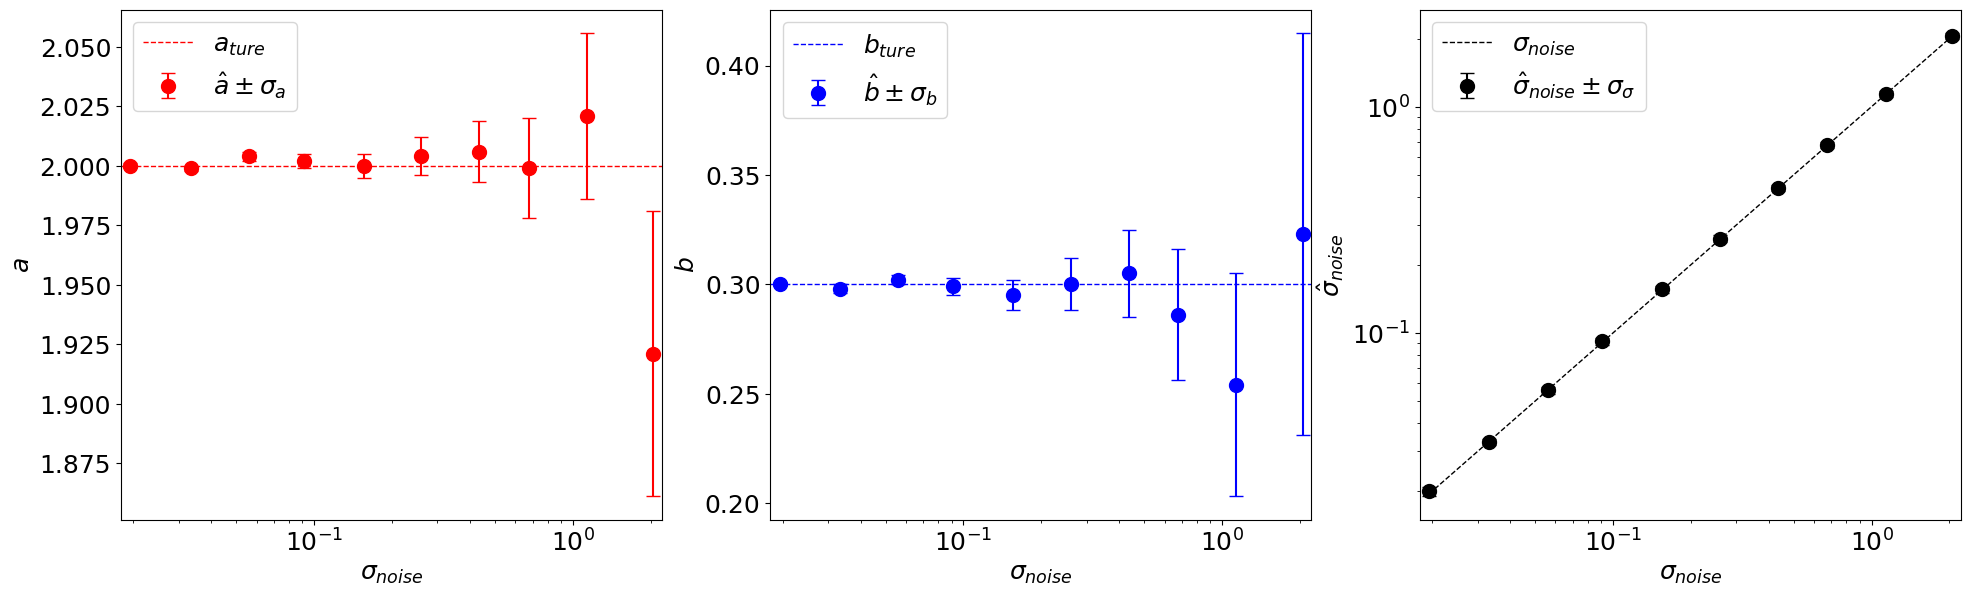

In [10]:
######################################
plt.rcParams['font.size'] = 18
#
fig = plt.figure( figsize=(20,6) )
fig.subplots_adjust(left=0.07, right=0.99, top=0.97, bottom=0.12)
#
######################################
ax1 = fig.add_subplot(1,3,1)
ax1.set_xlabel(r'$\sigma_{noise}$')
ax1.set_xscale('log')
ax1.set_ylabel(r'$a$')
#
(x_left, x_right) = ax1.set_xlim( 0.92 * np.amin(Y_noise_stds), 1.08 * np.amax(Y_noise_stds) )
#
# https://qiita.com/yuto_ohno/items/d2676e04f2d94fc30248
ax1.errorbar(Y_noise_stds, a_means, yerr = a_sds,
             capsize = 5, fmt ='o', markersize=10,
             color='red', ecolor='red',label=r'$\hat{a}\pm\sigma_{a}$')
#
(y_bot, y_top) = ax1.set_ylim()
#
ax1.hlines(a_true, x_left, x_right, \
           linestyles='dashed', color='red', linewidth=1.0, \
           label=r'$a_{ture}$')
#
ax1.legend()
#
######################################
ax2 = fig.add_subplot(1,3,2)
ax2.set_xlabel(r'$\sigma_{noise}$')
ax2.set_xscale('log')
ax2.set_ylabel(r'$b$')
#
(x_left, x_right) = ax2.set_xlim( 0.92 * np.amin(Y_noise_stds), 1.08 * np.amax(Y_noise_stds) )
#
# https://qiita.com/yuto_ohno/items/d2676e04f2d94fc30248
ax2.errorbar(Y_noise_stds, b_means, yerr = b_sds,
             capsize = 5, fmt ='o', markersize=10,
             color='blue', ecolor='blue', label=r'$\hat{b}\pm\sigma_{b}$')
#
(y_bot, y_top) = ax2.set_ylim()
#
ax2.hlines(b_true, x_left, x_right, \
           linestyles='dashed', color='blue', linewidth=1.0, label=r'$b_{ture}$' )
#
ax2.legend()
#
######################################
ax3 = fig.add_subplot(1,3,3)
ax3.set_xlabel(r'$\sigma_{noise}$')
ax3.set_xscale('log')
ax3.set_ylabel(r'$\hat{\sigma}_{noise}$')
ax3.set_yscale('log')
#
(x_left, x_right) = ax3.set_xlim( 0.92 * np.amin(Y_noise_stds), 1.08 * np.amax(Y_noise_stds) )
#
# https://qiita.com/yuto_ohno/items/d2676e04f2d94fc30248
ax3.errorbar(Y_noise_stds, rmsd_means, yerr = rmsd_sds,
             capsize = 5, fmt ='o', markersize=10,
             color='black', ecolor='black', label=r'$\hat{\sigma}_{noise}\pm\sigma_{\sigma}$')
#
(y_bot, y_top) = ax3.set_ylim()
#
ax3.plot(Y_noise_stds, Y_noise_stds, \
           linestyle='dashed', color='black', linewidth=1.0, label=r'$\sigma_{noise}$' )
#
ax3.legend()
#
######################################
# set path
pdfName = FilePath + FileBaseName + "-summary01.pdf"
fig.savefig( pdfName )

13. 事後確率分布の標準偏差$\sigma_{P(a|\boldsymbol{D})}$, $\sigma_{P(b|\boldsymbol{D})}$の$\sigma$による変化をまとめたグラフの描画

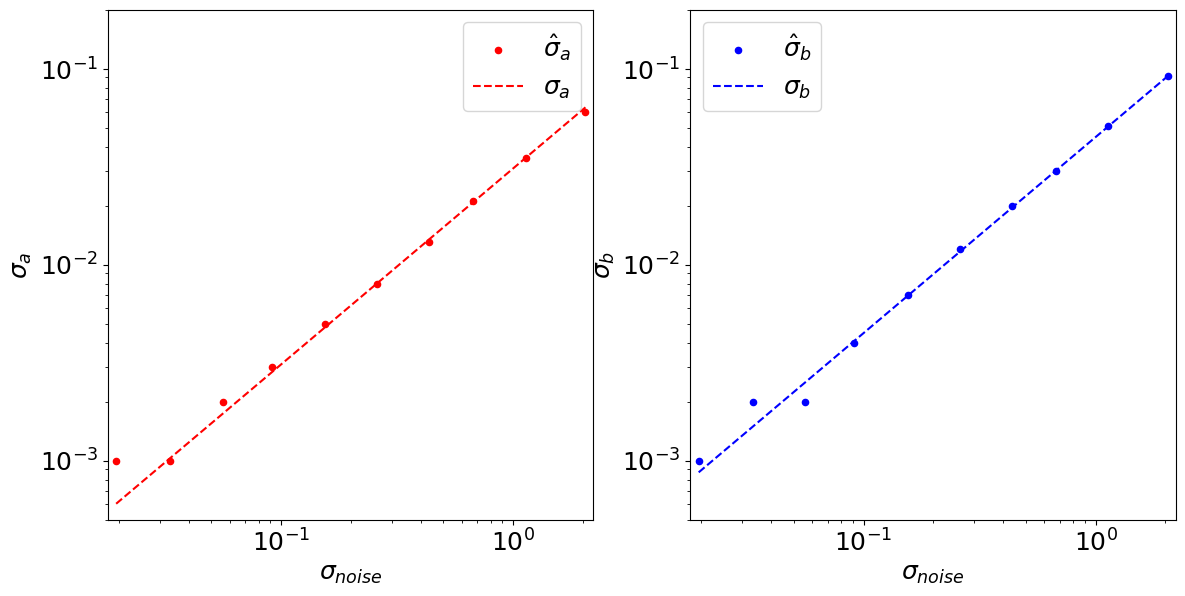

In [12]:
######################################
plt.rcParams['font.size'] = 18
#
fig = plt.figure( figsize=(12,6) )
fig.subplots_adjust(left=0.10, right=0.99, top=0.97, bottom=0.12)
#
######################################
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$\sigma_{noise}$')
ax1.set_xscale('log')
#
(x_left, x_right) = ax1.set_xlim( 0.92 * np.amin(Y_noise_stds), 1.08 * np.amax(Y_noise_stds) )
#
ax1.set_ylim(5.0E-4, 2E-1)
ax1.set_ylabel(r'$\sigma_{a}$')
ax1.set_yscale('log')
#
ax1.scatter(Y_noise_stds, a_sds, \
            color='red', s=20.0, label=r'$\hat{\sigma}_{a}$' )
#
ax1.plot( Y_noise_stds, sigmas_a, \
          linestyle='dashed', color='red', label=r'$\sigma_{a}$')
#
ax1.legend()
#
######################################
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel(r'$\sigma_{noise}$')
ax2.set_xscale('log')
#
(x_left, x_right) = ax2.set_xlim( 0.92 * np.amin(Y_noise_stds), 1.08 * np.amax(Y_noise_stds) )
#
ax2.set_ylim(5.0E-4, 2E-1)
#
ax2.set_ylabel(r'$\sigma_{b}$')
ax2.set_yscale('log')
#
ax2.scatter(Y_noise_stds, b_sds, \
            color='blue', s=20.0, label=r'$\hat{\sigma}_{b}$' )
#
ax2.plot( Y_noise_stds, sigmas_b, \
          linestyle='dashed', color='blue', label=r'$\sigma_{b}$')
#
ax2.legend()
#
######################################
# set path
pdfName = FilePath + FileBaseName + "-summary02.pdf"
fig.savefig( pdfName )